try to deal with multilines

In [51]:
import geopandas as gpd
import pandas as pd
from pathlib import Path
from shapely.geometry import Point, Polygon, LineString, MultiLineString
from shapely.ops import split
import csv

In [2]:
cgt_p = Path(r'D:\python\some_tools\centrostruct\ctow_test.txt')   # path to file

read and collect information to the list of structures

In [43]:
c_lines = []   # list of structures
with open(cgt_p, newline='') as f:
    reader = csv.reader(f, delimiter=' ')
    num_of_clines = 1   # number of c-line
    str_index = 1   # index of structure
    for row in reader:
        if len(row) == 4:
            # ctow file should contain id, x, y, z in each row
            # to c-lines list we add to each row index of stucture and number of c-line
            c_lines.append((str_index, num_of_clines, row[0], row[1], row[2], row[3]))
            str_index += 1   # index for next structure
        elif len(row) == 0:
            num_of_clines += 1    # blank row means next c-line follow
        else:
            print('ctow file error')

In [23]:
c_lines

[(1, 1, 't1', '1', '3', '1'),
 (2, 1, 't2', '3', '2', '2'),
 (3, 1, 't3', '5', '4', '1'),
 (4, 1, 't4', '4', '6', '1'),
 (5, 1, 't5', '5', '7', '1'),
 (6, 1, 't6', '7', '6', '2'),
 (7, 1, 't7', '8', '4', '1'),
 (8, 1, 't8', '9', '3', '2'),
 (9, 1, 't9', '8', '2', '1'),
 (10, 2, 't10', '1', '1', '2'),
 (11, 2, 't2', '3', '2', '2'),
 (12, 3, 't5', '5', '7', '1'),
 (13, 3, 't11', '4', '8', '2'),
 (14, 3, 't12', '3', '8', '1'),
 (15, 3, 't13', '1', '7', '1'),
 (16, 4, 't6', '7', '6', '2'),
 (17, 4, 't14', '9', '5', '2'),
 (18, 4, 't8', '9', '3', '2')]

In [158]:
c_lines_p = pd.DataFrame(c_lines, columns =['index', 'c_line', 'id', 'x', 'y', 'z']).set_index('index')

In [159]:
c_lines_p.head()

,c_line,id,x,y,z
index,,,,,
1,1,t1,1,3,1
2,1,t2,3,2,2
3,1,t3,5,4,1
4,1,t4,4,6,1
5,1,t5,5,7,1


In [162]:
c_lines_p = gpd.GeoDataFrame(c_lines_p, crs="EPSG:2193", geometry=gpd.points_from_xy(c_lines_p['x'], c_lines_p['y'], c_lines_p['z']))

In [163]:
c_lines_p.head()

,c_line,id,x,y,z,geometry
index,,,,,,
1,1,t1,1,3,1,POINT Z (1.00000 3.00000 1.00000)
2,1,t2,3,2,2,POINT Z (3.00000 2.00000 2.00000)
3,1,t3,5,4,1,POINT Z (5.00000 4.00000 1.00000)
4,1,t4,4,6,1,POINT Z (4.00000 6.00000 1.00000)
5,1,t5,5,7,1,POINT Z (5.00000 7.00000 1.00000)


In [114]:
len(c_lines_p)

18

In [129]:
# для коридоров достаточно 2д линий
coo_2d = []
line_n = 1
spam = []
for i in range(1, len(c_lines_p)+1):
    if c_lines_p.loc[i, 'c_line'] == line_n:
        spam.append((int(c_lines_p.loc[i].x), int(c_lines_p.loc[i].y)))
        if i == len(c_lines_p): coo_2d.append(tuple(spam))
    else:
        
        coo_2d.append(tuple(spam))
        spam = []
        line_n = c_lines_p.loc[i, 'c_line']
        spam.append((int(c_lines_p.loc[i].x), int(c_lines_p.loc[i].y)))

In [127]:
#  если нужны 3д линии
coo_3d = []
line_n = 1
spam = []
for i in range(1, len(c_lines_p)+1):
    if c_lines_p.loc[i, 'c_line'] == line_n:
        spam.append((int(c_lines_p.loc[i].x), int(c_lines_p.loc[i].y), int(c_lines_p.loc[i].z)))
        if i == len(c_lines_p): coo_3d.append(tuple(spam))
    else:
        
        coo_3d.append(tuple(spam))
        spam = []
        line_n = c_lines_p.loc[i, 'c_line']
        spam.append((int(c_lines_p.loc[i].x), int(c_lines_p.loc[i].y)))

In [97]:
type(c_lines_p.loc[1, 'x'])   # в блокноте это стр, в самом питоне не так ??? 

str

In [124]:
coo_2d

[((1, 3), (3, 2), (5, 4), (4, 6), (5, 7), (7, 6), (8, 4), (9, 3), (8, 2)),
 ((1, 1), (3, 2)),
 ((5, 7), (4, 8), (3, 8), (1, 7)),
 ((7, 6), (9, 5), (9, 3))]

In [164]:
m_lines_2d = MultiLineString(coo_2d)  # переводим в мультилинии

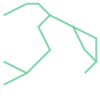

In [122]:
m_lines_2d

In [130]:
koridor_full = m_lines_2d.buffer(0.5)

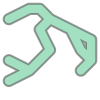

In [131]:
koridor_full

теперь усложняем - режем такой коридор поопорно   
разрезать такой целиковый коридор будет довольно сложно,   
поэтому лучше будет построить отдельно коридор на каждую линию, а затем объединить общие участки

In [147]:
mid_points = []
str_boxes = []


for line in m_lines_2d.geoms:
    kor_spam = line.buffer(0.5)
    for i in range(len(line.coords)-1):
        mp = LineString([line.coords[i], line.coords[i+1]]).interpolate(0.5, normalized = True)   # mid point
        mid_points.append(mp)
        spam = LineString([line.coords[i], mp])       # line from str to mid 
        left = spam.parallel_offset(0.6, 'left')      # left parallel line
        right = spam.parallel_offset(0.6, 'right')    # right parallel line
        xline = LineString([left.boundary[1], right.boundary[0]])    # x-line - connect ends of parallels

        cut = split(kor_spam, xline)
        if Point(line.coords[i]).within(cut[0]):
            str_boxes.append(cut[0])
            kor_spam = cut[1]
        else:
            str_boxes.append(cut[1])
            kor_spam = cut[0]
        
    str_boxes.append(kor_spam)

In [148]:
len(mid_points), len(str_boxes)

(14, 18)

<AxesSubplot:>

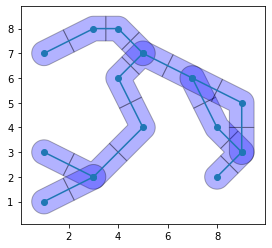

In [155]:
ax = gpd.GeoSeries(str_boxes).plot(color='blue', edgecolor='black', alpha=0.3)
gpd.GeoSeries(m_lines_2d).plot(ax=ax)
c_lines_p.plot(ax=ax)

теперь надо объединить узловые боксы  
для этого надо найти узловые точки, а заодно и список уникальных координат опор  

In [166]:
c_lines_p.head()

,c_line,id,x,y,z,geometry
index,,,,,,
1,1,t1,1,3,1,POINT Z (1.00000 3.00000 1.00000)
2,1,t2,3,2,2,POINT Z (3.00000 2.00000 2.00000)
3,1,t3,5,4,1,POINT Z (5.00000 4.00000 1.00000)
4,1,t4,4,6,1,POINT Z (4.00000 6.00000 1.00000)
5,1,t5,5,7,1,POINT Z (5.00000 7.00000 1.00000)
